# 19. Goal-Oriented Reinforcement Learning (GoRL)

## 19.1. Intro
目标导向的强化学习

## 19.2. Problem Definition

$$
r_g(s_t, a_t, s_{t + 1}) = \left\{ 
\begin{aligned}
&0, &||\phi(s_{t+1} - g)||_2 \leq \delta_g \\ 
&-1, &\text{otherwise} 
\end{aligned}
\right.
$$

$\mathbb{E}_{(s_0, g) \sim \nu_0}[V^\pi(s_0, g)]$

## 19.3. HER Algo
事后经验回放：hindsight experience replay (HER)

伪代码 HER：
1. 初始化策略和他的参数$\pi$, $\theta$, 初始化经验回放池$R$
2. **for**  序列 $e = 0 \rightarrow E$ **do**:
   1. 根据环境给予目标$g$和初始状态$s_0$, 使用$\pi$在环境中采样得到轨迹$\{s_0, a_0, r_0, ..., ..., s_T, a_T, r_T, s_{T+1}\}$, 将其以$(s, a, r, s', g)$的形式存入$R$中
   2. 从$R$中采样$N$个$(s, a, r, s', g)$元组
   3. 对于这些元组，选择一个状态$s"$, 将其映射为新的目标$g' = \phi(s")$, 计算新的奖励值$r' = r_{g'}(s, a, s')$, 然后用新的数据$(s, a, r', s', g')$替换原先的元组
3. **end for**

$s"$选择，有三种
1. future: 选择与被改写的元组$\{s, a, s', g\}$处于同一轨迹并在时间上处于$s$之后的某个状态为$s"$
2. episode: 选择与被改写的元组$\{s, a, s', g\}$处于同一轨迹的某个状态$s"$
3. random: 选择经验回放池中的某个状态作为$s"$

实验中选择future方案

## 19.4. HER code


In [28]:

import torch
import torch.nn.functional as F
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt

class WorldEnv:
  def __init__(self):
    self.distance_threshold = 0.15
    self.action_bound = 1
    
  def reset(self): # 重置环境
    # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
    self.goal = np.array(
      [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)]
    )
    self.state = np.array([0, 0]) # 初始状态
    self.count = 0
    return np.hstack((self.state, self.goal))
  
  def step(self, action):
    action = np.clip(action, -self.action_bound, self.action_bound)
    x = max(0, min(5, self.state[0] + action[0]))
    y = max(0, min(5, self.state[1] + action[1]))
    self.state = np.array([x, y])
    self.count += 1
    
    dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
    reward = -1.0 if dis > self.distance_threshold else 0
    if dis <= self.distance_threshold or self.count == 50:
      done = True
    else:
      done = False
      
    return np.hstack((self.state, self.goal)), reward, done


In [29]:
class PolicyNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
    self.action_bound = action_bound # 可接受的动作最大值
    
  def forward(self, x):
    x = F.relu(self.fc2(F.relu(self.fc1(x)))) 
    return torch.tanh(self.fc3(x)) * self.action_bound
  
class QValueNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, 1)
    
  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1) # 拼接状态和动作
    x = F.relu(self.fc2(F.relu(self.fc1(cat))))
    return self.fc3(x)

In [30]:
class DDPG:
  '''DDPG 算法'''
  def __init__(self, state_dim, hidden_dim, action_dim, 
              action_bound, actor_lr, critic_lr,sigma, 
              tau, gamma, device):
    self.action_dim = action_dim
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    # 初始化目标价值网络并设置和价值网络相同的参数
    self.target_critic.load_state_dict(self.critic.state_dict())
    # 初始化目标策略网络并设置和策略相同的参数
    self.target_actor.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.sigma = sigma # 高斯噪声的标准差，均值直接设为0
    self.tau = tau # 目标网络软更新参数
    self.action_dim = action_dim
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state).detach().cpu().numpy()[0]
    # 给动作增加噪声，增加探索
    action = action + self.sigma * np.random.randn(self.action_dim)
    return action
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
      
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], 
                            dtype=torch.float).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
      
    next_q_values = self.target_critic(next_states, self.target_actor(next_states))
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    # MSE 损失函数
    critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()
    
    # 策略网络就是为了使Q值最大化
    actor_loss = -torch.mean(self.critic(states, self.actor(states)))
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    self.soft_update(self.actor, self.target_actor) # 软更新策略网络
    self.soft_update(self.critic, self.target_critic) # 软更新价值网络

In [31]:
class Trajectory:
  ''' 用来记录一条完整轨迹 '''
  def __init__(self, init_state):
    self.states = [init_state]
    self.actions = []
    self.rewards = []
    self.dones = []
    self.length = 0
    
  def store_step(self, action, state, reward, done):
    self.actions.append(action)
    self.states.append(state)
    self.rewards.append(reward)
    self.dones.append(done)
    self.length += 1
    
class ReplayBuffer_Trajectory:
  ''' 存储轨迹的经验回放池 '''
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)
    
  def add_trajectory(self, trajectory):
    self.buffer.append(trajectory)
    
  def size(self):
    return len(self.buffer)
  
  def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
    batch = dict(
      states = [],
      actions = [],
      next_states = [],
      rewards = [],
      dones = []
    )
    for _ in range(batch_size):
      traj = random.sample(self.buffer, 1)[0]
      step_state = np.random.randint(traj.length)
      state = traj.states[step_state]
      next_state = traj.states[step_state + 1]
      action = traj.actions[step_state]
      reward = traj.rewards[step_state]
      done = traj.dones[step_state]
      
      if use_her and np.random.uniform() <= her_ratio:
        step_goal = np.random.randint(step_state + 1, traj.length + 1)
        goal = traj.states[step_goal][:2] # 使用HER算法的future方案设置目标
        dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
        reward = -1.0 if dis > dis_threshold else 0
        done = False if dis > dis_threshold else True
        state = np.hstack((state[:2], goal))
        next_state = np.hstack((next_state[:2], goal))
        
      batch['states'].append(state)
      batch['next_states'].append(next_state)
      batch['actions'].append(action)
      batch['rewards'].append(reward)
      batch['dones'].append(done)
      
    batch['states'] = np.array(batch['states'])
    batch['next_states'] = np.array(batch['next_states'])
    batch['actions'] = np.array(batch['actions'])
    return batch

Iteration 9: 100%|██████████| 200/200 [01:16<00:00,  2.63it/s, episode=2000, return=-4.100]


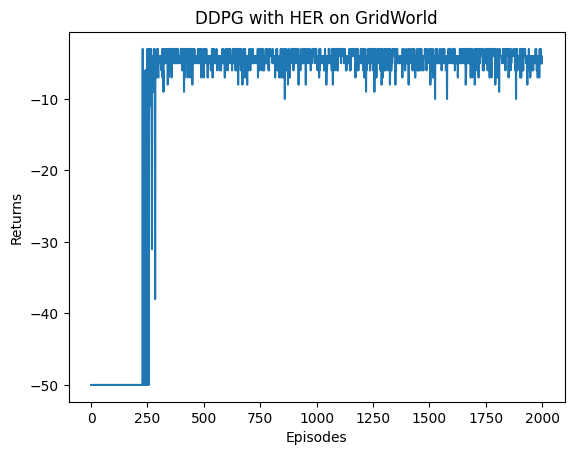

In [32]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005 
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,
            actor_lr, critic_lr, sigma, tau, gamma, device)
return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      episode_return = 0
      state = env.reset()
      traj = Trajectory(state)
      done = False
      while not done:
        action = agent.take_action(state)
        state, reward, done = env.step(action)
        episode_return += reward
        traj.store_step(action, state, reward, done)
      replay_buffer.add_trajectory(traj)
      return_list.append(episode_return)
      if replay_buffer.size() >= minimal_episodes:
        for _ in range(n_train):
          transition_dict = replay_buffer.sample(batch_size, True)
          agent.update(transition_dict)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
          'episode':
          '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return':
            '%.3f' % np.mean(return_list[-10:])
        })
      pbar.update(1)
      
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()
        

Iteration 9: 100%|██████████| 200/200 [00:50<00:00,  3.98it/s, episode=2000, return=-50.000]


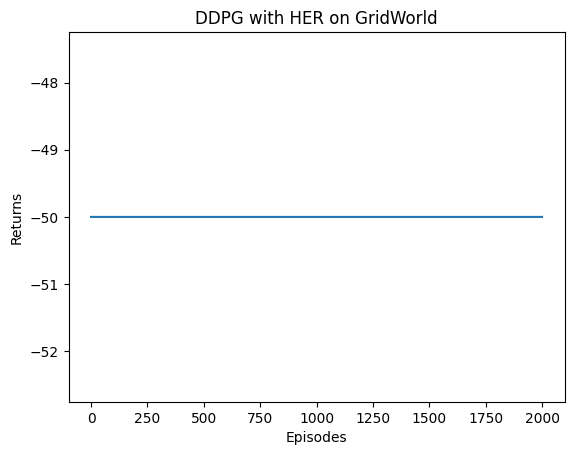

In [33]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,
            actor_lr, critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      episode_return = 0
      state = env.reset()
      traj = Trajectory(state)
      done = False
      while not done:
        action = agent.take_action(state)
        state, reward, done = env.step(action)
        episode_return += reward
        traj.store_step(action, state, reward, done)
      replay_buffer.add_trajectory(traj)
      return_list.append(episode_return)
      if replay_buffer.size() >= minimal_episodes:
        for _ in range(n_train):
          # 区别
          transition_dict = replay_buffer.sample(batch_size, False)
          agent.update(transition_dict)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
          'episode':
          '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return':
          '%.3f' % np.mean(return_list[-10:])
        })
      pbar.update(1)
      
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()
        